In [12]:
%matplotlib inline
import os, struct
from array import array as pyarray
import numpy as np
from scipy.cluster.vq import *
from numpy import append, array, int8, uint8, zeros
from pylab import *
from numpy import *

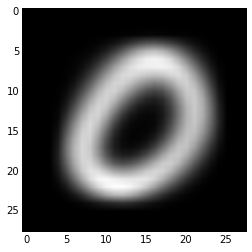

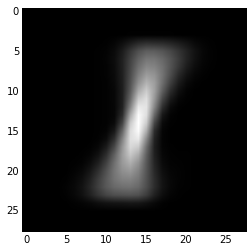

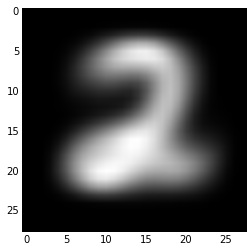

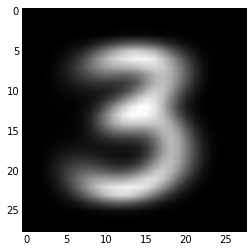

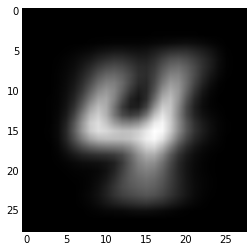

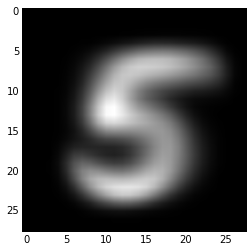

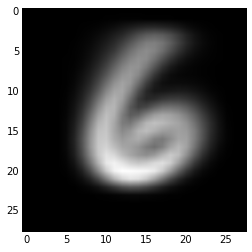

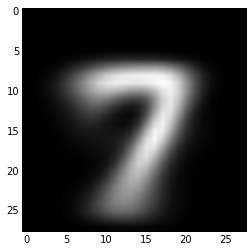

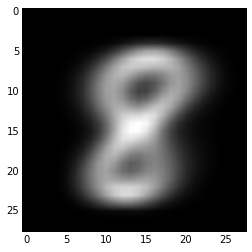

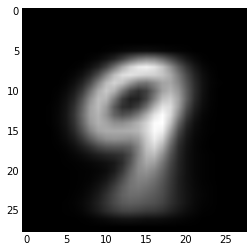

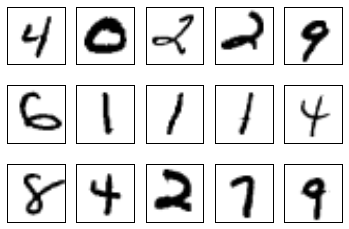

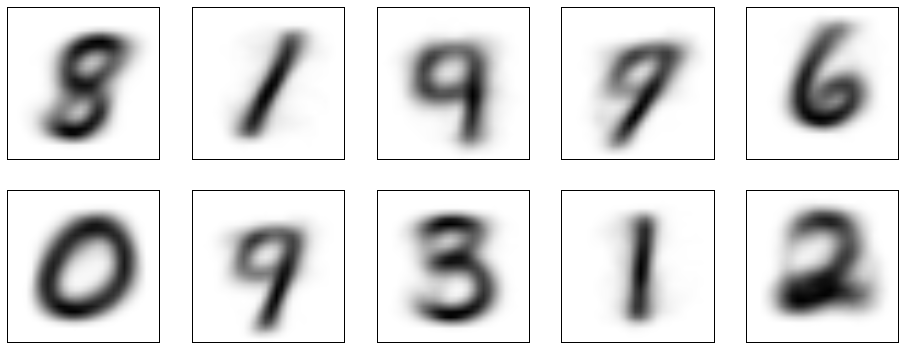

In [13]:
from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import matplotlib
import pylab
import matplotlib.pyplot as plt 
mnist = fetch_mldata('MNIST original', data_home='./data')
X_digits, _,_, Y_digits = mnist.values() # fetch dataset from internet
images0 = []
images1 = []
images2 = []
images3 = []
images4 = []
images5 = []
images6 = []
images7 = []
images8 = []
images9 = []
for i in range(len(Y_digits)):
    if Y_digits[i] == 0.0:
        images0.append(X_digits[i])
    elif Y_digits[i] == 1.0:
        images1.append(X_digits[i])
    elif Y_digits[i] == 2.0:
        images2.append(X_digits[i])
    elif Y_digits[i] == 3.0:
        images3.append(X_digits[i])
    elif Y_digits[i] == 4.0:
        images4.append(X_digits[i])
    elif Y_digits[i] == 5.0:
        images5.append(X_digits[i])
    elif Y_digits[i] == 6.0:
        images6.append(X_digits[i])
    elif Y_digits[i] == 7.0:
        images7.append(X_digits[i])
    elif Y_digits[i] == 8.0:
        images8.append(X_digits[i])
    elif Y_digits[i] == 9.0:
        images9.append(X_digits[i])
mnist_true_center = []
mnist_true_center.append(np.array(images0).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images1).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images2).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images3).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images4).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images5).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images6).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images7).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images8).mean(axis=0).reshape(28,28))
mnist_true_center.append(np.array(images9).mean(axis=0).reshape(28,28))


imshow(mnist_true_center[0], cmap=cm.gray)
show()
imshow(mnist_true_center[1], cmap=cm.gray)
show()
imshow(mnist_true_center[2], cmap=cm.gray)
show()
imshow(mnist_true_center[3], cmap=cm.gray)
show()
imshow(mnist_true_center[4], cmap=cm.gray)
show()
imshow(mnist_true_center[5], cmap=cm.gray)
show()
imshow(mnist_true_center[6], cmap=cm.gray)
show()
imshow(mnist_true_center[7], cmap=cm.gray)
show()
imshow(mnist_true_center[8], cmap=cm.gray)
show()
imshow(mnist_true_center[9], cmap=cm.gray)
show()

X_digits, Y_digits = shuffle(X_digits,Y_digits) # shuffle dataset (which is     ordered!)
X_digits = X_digits[-5000:]
plt.rc("image", cmap="binary") # use black/white palette for plotting
for i in xrange(15):
    plt.subplot(3,5,i+1)
    plt.imshow(X_digits[10+i].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
plt.show()
kmeans = KMeans(10)
mu_digits = kmeans.fit(X_digits).cluster_centers_


plt.figure(figsize=(16,6))
for i in xrange(2*(mu_digits.shape[0]/2)): # loop over all means
    plt.subplot(2,mu_digits.shape[0]/2,i+1)
    plt.imshow(mu_digits[i].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
plt.show()

In [14]:
def load_mnist(dataset="training", digits=np.arange(10), path="."):
    """
    Loads MNIST files into 3D numpy arrays

    Adapted from: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
    """

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows, cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels

In [15]:
# images0, label = load_mnist('training', digits=[0])
# images1, label = load_mnist('training', digits=[1])
# images2, label = load_mnist('training', digits=[2])
# images3, label = load_mnist('training', digits=[3])
# images4, label = load_mnist('training', digits=[4])
# images5, label = load_mnist('training', digits=[5])
# images6, label = load_mnist('training', digits=[6])
# images7, label = load_mnist('training', digits=[7])
# images8, label = load_mnist('training', digits=[8])
# images9, label = load_mnist('training', digits=[9])

# imshow(images0.mean(axis=0), cmap=cm.gray)
# show()
# imshow(images1.mean(axis=0), cmap=cm.gray)
# show()
# imshow(images2.mean(axis=0), cmap=cm.gray)
# show()
# imshow(images3.mean(axis=0), cmap=cm.gray)
# show()
# imshow(images4.mean(axis=0), cmap=cm.gray)
# show()
# imshow(images5.mean(axis=0), cmap=cm.gray)
# show()
# imshow(images6.mean(axis=0), cmap=cm.gray)
# show()
# imshow(images7.mean(axis=0), cmap=cm.gray)
# show()
# imshow(images8.mean(axis=0), cmap=cm.gray)
# show()
# imshow(images9.mean(axis=0), cmap=cm.gray)
# show()

    